In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [3]:
dataset

{'test': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [4]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [5]:
train_dataset, test_dataset = dataset["train"], dataset["test"]

In [6]:
batch_size = 64
shuffle_size = 10000
train_dataset = train_dataset.shuffle(shuffle_size)

# padded_batch:使用 padded_batch 方法将序列零填充至批次中最长字符串的长度：
train_dataset = train_dataset.padded_batch(batch_size)
test_dataset = test_dataset.padded_batch(batch_size)

In [7]:
tokenized = info.features["text"].encoder
tokenized.vocab_size

8185

In [8]:
sample_string = "Tensorflow is cool"
encoded_string = tokenized.encode(sample_string)
encoded_string

[6307, 2327, 2934, 7961, 9, 2724]

In [9]:
decode_string = tokenized.decode(encoded_string) 
decode_string

'Tensorflow is cool'

In [10]:
for code in encoded_string:
    print("{} => {}".format(code, tokenized.decode([code])))

6307 => Ten
2327 => sor
2934 => flow
7961 =>  
9 => is 
2724 => cool


In [11]:
def build_model(vocab_size, embedding_dim,  units):
    model = keras.models.Sequential([
        keras.layers.Embedding(
            input_dim = vocab_size, 
            output_dim = embedding_dim),
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                units=units, 
                return_sequences=False)),
        keras.layers.Dense(units, activation="relu"),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    return model

In [12]:
vocab_size=tokenized.vocab_size 
embedding_dim=16
batch_size=512

model_lstm = build_model(vocab_size, embedding_dim, 32)

In [13]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 145,617
Trainable params: 145,617
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_lstm.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

history = model_lstm.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 348s 890ms/step - loss: 0.6954 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
391/391 [==============================] - 313s 800ms/step - loss: 0.6887 - accuracy: 0.5178 - val_loss: 0.6518 - val_accuracy: 0.6862
Epoch 3/10
391/391 [==============================] - 321s 821ms/step - loss: 0.6297 - accuracy: 0.7072 - val_loss: 0.6376 - val_accuracy: 0.6946
Epoch 4/10
391/391 [==============================] - 378s 966ms/step - loss: 0.6071 - accuracy: 0.7719 - val_loss: 0.6181 - val_accuracy: 0.7469
Epoch 5/10
391/391 [==============================] - 332s 850ms/step - loss: 0.6003 - accuracy: 0.7868 - val_loss: 0.6173 - val_accuracy: 0.7433
Epoch 6/10
391/391 [==============================] - 367s 938ms/step - loss: 0.5926 - accuracy: 0.8045 - val_loss: 0.6379 - val_accuracy: 0.7227
Epoch 7/10
391/391 [==============================] - 349s 892ms/step - loss: 0.6084 - accuracy: 0.7831 - val_loss: 0.6120 -

In [15]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()

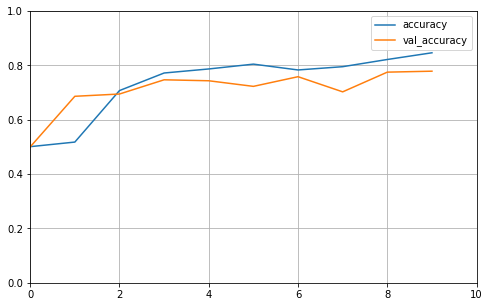

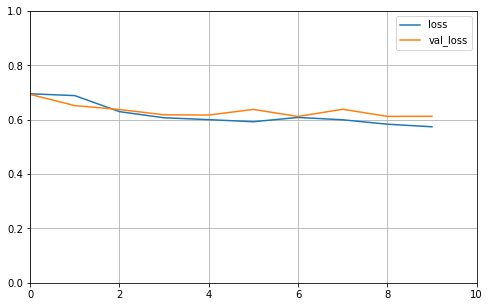

In [16]:
plot_learning_curves(history, "accuracy", 10, 0, 1)
plot_learning_curves(history, "loss", 10, 0, 1)